In [9]:
using LaTeXStrings
using StatsPlots
using PrettyTables
using Distributions
using StatsBase
using Corpuscles
using UnicodeFun
using FastJet
using CxxWrap: StdVector
using LCIO
using LinearAlgebra
using JLD2
#pyplot()
#gr()
#theme(:gruvbox_dark)

In [2]:
fileList_ss = filter(s->occursin(r"E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_bb = filter(s->occursin(r"E250_SetA.Pmumuh2bb.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_cc = filter(s->occursin(r"E250_SetA.Pmumuh2cc.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_gg = filter(s->occursin(r"E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

print("ss has ")
print(length(fileList_ss))
print(" files, bb has ")
print(length(fileList_bb))
print(" files, cc has ")
print(length(fileList_cc))
print(" files, gg has ")
print(length(fileList_gg))
print(" files")
sampleList=[fileList_ss, fileList_bb, fileList_cc, fileList_gg]

ss has 100 files, bb has 100 files, cc has 100 files, gg has 100 files

4-element Array{Array{String,1},1}:
 ["/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.0_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.10_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.11_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.12_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.13_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.14_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.15_DST.slcio", "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8.pR0.3.16_DST.slcio", "/nfs/dust/ilc/user/jstrube

In [3]:
function jetConstituentP(constituent)
    a=FastJet.px(constituent)::Float64
    b=FastJet.py(constituent)::Float64
    c=FastJet.pz(constituent)::Float64
    return (a,b,c)
end

function leadingParticleIndex(jet)
    momentumList = []
    highestMomentum = 0
    nCon = 0
    index = 0
    for c in constituents(jet)
        nCon+=1
        p=jetConstituentP(c)
        if dot(p, p)>highestMomentum
            highestMomentum=dot(p, p)
            index=nCon
        end
    end
    return index
end

function invMassSum(particle_1, particle_2)
    a = sqrt((getEnergy(particle_1)+getEnergy(particle_2))^2-
        dot(getMomentum(particle_1)+getMomentum(particle_2),
            getMomentum(particle_1)+getMomentum(particle_2)))
    return a
end

function recoil_mass(μ₁, μ₂)
    E_initial = 250.0  #can update to make it accurate for the event's flucation, with p as well?
    px_initial = 0.0
    recoilE = E_initial - getEnergy(μ₁) - getEnergy(μ₂)
    recoilP = [px_initial, 0, 0] - getMomentum(μ₁) - getMomentum(μ₂)
    return sqrt(recoilE^2 - sum(recoilP.^2))
end

recoil_mass (generic function with 1 method)

In [4]:
function zMuonIndices(event, threshold, MCTruth=false) #for certain events it returns an empty candidatePairs
    
    iParticle = 0
    posMuonList = []
    negMuonList = []
    if MCTruth==false
        collection = getCollection(event, "PandoraPFOs")
        recoLinks = getCollection(event, "RecoMCTruthLink")
        rel=LCIO.LCRelationNavigator(recoLinks)
    elseif MCTruth==true
        collection = getCollection(event, "MCParticle")
    end
    
    for particle in collection
        if MCTruth==false
            mcp = getRelatedToObjects(rel, particle)
            if length(mcp)>0
                MCparticle=mcp[1]
            else
                continue
            end
        elseif MCTruth==true
            MCparticle=particle
        end
        iParticle += 1
        if abs(getPDG(MCparticle))==13 && getGeneratorStatus(MCparticle)==1
            if getCharge(MCparticle)==1
                push!(posMuonList, (particle, iParticle))
            elseif getCharge(MCparticle)==-1
                push!(negMuonList, (particle, iParticle))
            end
        end
    end
    
    candidatePair=[]
    
    candidateDiff=91.187
    for item_pos in posMuonList    
        posParticle = item_pos[1]
        for item_neg in negMuonList
            negParticle = item_neg[1]
            if abs(91.187-invMassSum(posParticle, negParticle))<abs(candidateDiff)
                candidateDiff=91.187-invMassSum(posParticle, negParticle)
                candidatePair=[item_pos, item_neg]
            end
        end
    end
    
    if abs(candidateDiff)>threshold
        indices=[0,0]
    elseif length(candidatePair)>0
        indices = [candidatePair[1][2], candidatePair[2][2]]
    end
    return indices
end

zMuonIndices (generic function with 2 methods)

perSampleFalsePosIndex = Dict()
perSamplePurity = Dict()
perSampleNoParents = Dict()
perSampleRecoPDG = Dict()
differenceList = Dict()
recoilMass = Dict()
efficiencyList=Dict()
nEvent=Dict()

In [25]:
@load "FalsePosIndex"
@load "NoParents"
@load "RecoPDG"
@load "DifferenceList"
@load "nEvents"
@load "Purity"
@load "Efficiencies"
#@load "RecoilMass" JDL2 isnt loading this but it worked before and the correct plot is below

1-element Array{Symbol,1}:
 :efficiencyList

In [17]:
@time for sample in [fileList_ss]
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[]
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    perSampleRecoilMass = []
    for FILENAME in sample
        iFile+=1
   #     if iFile>2
  #          break
   #     end
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            for event in reader
                iEvent+=1
   #             if iEvent>10
  #                  break
    #            end
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10)
                MC_zMuonIndex = zMuonIndices(event, 10, true)
                mcCollection = getCollection(event, "MCParticle")
                #print(zMuonIndex)
                haveParents=false
                firstIsDaughterOfZ=false
                areDaughtersOfZ=false
                noParents=true
                recoMuon1=[]
                recoMuon2=[]
                for (iParticle, particle) in enumerate(collection)
                    mcp = getRelatedToObjects(rel, particle)
                    if length(mcp)>0
                        MCParticle=mcp[1]
                    else
                        continue
                    end

                    if iParticle in RP_zMuonIndex
                        
                        if recoMuon1!=[] 
                            recoMuon2=particle
                        end
                        if firstIsDaughterOfZ==false
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if firstIsDaughterOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        firstIsDaughterOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                    
                    if iParticle in RP_zMuonIndex
                        if recoMuon1==[] 
                            recoMuon1=particle
                        end
                        if firstIsDaughterOfZ==true
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if areDaughtersOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        areDaughtersOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                end
                
                mcMuon1=[]
                mcMuon2=[]
                for (iParticle, particle) in enumerate(mcCollection)

                    if iParticle in MC_zMuonIndex && mcMuon1!=[]
                        mcMuon2=particle
                    end
                    if iParticle in MC_zMuonIndex && mcMuon1==[]
                        mcMuon1=particle
                    end
                end
                
                if recoMuon2!=[] && mcMuon2!=[]
                    push!(perSampleDifferenceList, invMassSum(recoMuon1, recoMuon2)-invMassSum(mcMuon1, mcMuon2))
                    push!(perSampleRecoilMass, recoil_mass(recoMuon1, recoMuon2))
                end
                
                
                
               if areDaughtersOfZ==false
                   nFalsePos+=1
                   push!(falsePosEventIndexList, (iFile, iEvent))
               end
            end
            push!(perFilePurity, nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    perSampleFalsePosIndex["ss"] = falsePosEventIndexList
    perSamplePurity["ss"] = mean(perFilePurity)
    perSampleNoParents["ss"] = mean(perFileNoParents)
    perSampleRecoPDG["ss"] = recoPDG
    differenceList["ss"] = perSampleDifferenceList
    recoilMass["ss"] = perSampleRecoilMass
    
    @save "FalsePosIndex" perSampleFalsePosIndex
    @save "Purity" perSamplePurity
    @save "NoParents" perSampleNoParents
    @save "RecoPDG" perSampleRecoPDG
    @save "DifferenceList" differenceList
    @save "RecoilMass" recoilMass
end


480.358280 seconds (359.89 M allocations: 9.875 GiB, 0.52% gc time)


In [7]:
@time for sample in [fileList_bb]
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[]
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    perSampleRecoilMass = []
    for FILENAME in sample
        iFile+=1
   #     if iFile>2
  #          break
   #     end
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            for event in reader
                iEvent+=1
   #             if iEvent>10
  #                  break
    #            end
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10)
                MC_zMuonIndex = zMuonIndices(event, 10, true)
                mcCollection = getCollection(event, "MCParticle")
                #print(zMuonIndex)
                haveParents=false
                firstIsDaughterOfZ=false
                areDaughtersOfZ=false
                noParents=true
                recoMuon1=[]
                recoMuon2=[]
                for (iParticle, particle) in enumerate(collection)
                    mcp = getRelatedToObjects(rel, particle)
                    if length(mcp)>0
                        MCParticle=mcp[1]
                    else
                        continue
                    end

                    if iParticle in RP_zMuonIndex
                        
                        if recoMuon1!=[] 
                            recoMuon2=particle
                        end
                        if firstIsDaughterOfZ==false
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if firstIsDaughterOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        firstIsDaughterOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                    
                    if iParticle in RP_zMuonIndex
                        if recoMuon1==[] 
                            recoMuon1=particle
                        end
                        if firstIsDaughterOfZ==true
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if areDaughtersOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        areDaughtersOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                end
                
                mcMuon1=[]
                mcMuon2=[]
                for (iParticle, particle) in enumerate(mcCollection)

                    if iParticle in MC_zMuonIndex && mcMuon1!=[]
                        mcMuon2=particle
                    end
                    if iParticle in MC_zMuonIndex && mcMuon1==[]
                        mcMuon1=particle
                    end
                end
                
                if recoMuon2!=[] && mcMuon2!=[]
                    push!(perSampleDifferenceList, invMassSum(recoMuon1, recoMuon2)-invMassSum(mcMuon1, mcMuon2))
                    push!(perSampleRecoilMass, recoil_mass(recoMuon1, recoMuon2))
                end
                
                
                
               if areDaughtersOfZ==false
                   nFalsePos+=1
                   push!(falsePosEventIndexList, (iFile, iEvent))
               end
            end
            push!(perFilePurity, nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    perSampleFalsePosIndex["bb"] = falsePosEventIndexList
    perSamplePurity["bb"] = mean(perFilePurity)
    perSampleNoParents["bb"] = mean(perFileNoParents)
    perSampleRecoPDG["bb"] = recoPDG
    differenceList["bb"] = perSampleDifferenceList
    recoilMass["bb"] = perSampleRecoilMass
    
    @save "FalsePosIndex" perSampleFalsePosIndex
    @save "Purity" perSamplePurity
    @save "NoParents" perSampleNoParents
    @save "RecoPDG" perSampleRecoPDG
    @save "DifferenceList" differenceList
    @save "RecoilMass" recoilMass
end


525.365535 seconds (412.85 M allocations: 11.596 GiB, 0.55% gc time)


In [ ]:
@time for sample in [fileList_cc]
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[]
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    perSampleRecoilMass = []
    for FILENAME in sample
        iFile+=1
#        if iFile>3
 #           break
  #      end
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            for event in reader
                iEvent+=1
   #             if iEvent>100
    #                break
     #           end
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10)
                MC_zMuonIndex = zMuonIndices(event, 10, true)
                mcCollection = getCollection(event, "MCParticle")
                #print(zMuonIndex)
                haveParents=false
                firstIsDaughterOfZ=false
                areDaughtersOfZ=false
                noParents=true
                recoMuon1=[]
                recoMuon2=[]
                for (iParticle, particle) in enumerate(collection)
                    mcp = getRelatedToObjects(rel, particle)
                    if length(mcp)>0
                        MCParticle=mcp[1]
                    else
                        continue
                    end

                    if iParticle in RP_zMuonIndex
                        
                        if recoMuon1!=[] 
                            recoMuon2=particle
                        end
                        if firstIsDaughterOfZ==false
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if firstIsDaughterOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        firstIsDaughterOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                    
                    if iParticle in RP_zMuonIndex
                        if recoMuon1==[] 
                            recoMuon1=particle
                        end
                        if firstIsDaughterOfZ==true
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if areDaughtersOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        areDaughtersOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                end
                
                mcMuon1=[]
                mcMuon2=[]
                for (iParticle, particle) in enumerate(mcCollection)

                    if iParticle in MC_zMuonIndex && mcMuon1!=[]
                        mcMuon2=particle
                    end
                    if iParticle in MC_zMuonIndex && mcMuon1==[]
                        mcMuon1=particle
                    end
                end
                
                if recoMuon2!=[] && mcMuon2!=[]
                    push!(perSampleDifferenceList, invMassSum(recoMuon1, recoMuon2)-invMassSum(mcMuon1, mcMuon2))
                    push!(perSampleRecoilMass, recoil_mass(recoMuon1, recoMuon2))
                end
                
                
                
               if areDaughtersOfZ==false
                   nFalsePos+=1
                   push!(falsePosEventIndexList, (iFile, iEvent))
               end
            end
            push!(perFilePurity, nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    perSampleFalsePosIndex["cc"] = falsePosEventIndexList
    perSamplePurity["cc"] = mean(perFilePurity)
    perSampleNoParents["cc"] = mean(perFileNoParents)
    perSampleRecoPDG["cc"] = recoPDG
    differenceList["cc"] = perSampleDifferenceList
    recoilMass["cc"] = perSampleRecoilMass
    
    @save "FalsePosIndex" perSampleFalsePosIndex
    @save "Purity" perSamplePurity
    @save "NoParents" perSampleNoParents
    @save "RecoPDG" perSampleRecoPDG
    @save "DifferenceList" differenceList
    @save "RecoilMass" recoilMass
end

In [19]:
@time for sample in [fileList_gg]
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[]
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    perSampleRecoilMass = []
    for FILENAME in sample
        iFile+=1
#        if iFile>3
 #           break
  #      end
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            for event in reader
                iEvent+=1
   #             if iEvent>100
    #                break
     #           end
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10)
                MC_zMuonIndex = zMuonIndices(event, 10, true)
                mcCollection = getCollection(event, "MCParticle")
                #print(zMuonIndex)
                haveParents=false
                firstIsDaughterOfZ=false
                areDaughtersOfZ=false
                noParents=true
                recoMuon1=[]
                recoMuon2=[]
                for (iParticle, particle) in enumerate(collection)
                    mcp = getRelatedToObjects(rel, particle)
                    if length(mcp)>0
                        MCParticle=mcp[1]
                    else
                        continue
                    end

                    if iParticle in RP_zMuonIndex
                        
                        if recoMuon1!=[] 
                            recoMuon2=particle
                        end
                        if firstIsDaughterOfZ==false
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if firstIsDaughterOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        firstIsDaughterOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                    
                    if iParticle in RP_zMuonIndex
                        if recoMuon1==[] 
                            recoMuon1=particle
                        end
                        if firstIsDaughterOfZ==true
                            if length(getParents(MCParticle))>0
                                noParents=false
                            elseif length(getParents(MCParticle))==0
                                nNoParents+=1
                                push!(noParentIndexList, (iFile, iEvent))
                            end
                            push!(recoPDG, getPDG(MCParticle))
                            lineage=getParents(MCParticle)
                            while length(lineage)>0
                                nextGen=[]
                                for parent in lineage
                                    if areDaughtersOfZ==true
                                        lineage=[]
                                        break
                                    end
                                    if abs(getPDG(parent))==23
                                        areDaughtersOfZ=true
                                    end
                                    for grandparent in getParents(parent)
                                        push!(nextGen, grandparent)
                                    end
                                end
                                lineage=nextGen
                            end
                        end
                    end
                end
                
                mcMuon1=[]
                mcMuon2=[]
                for (iParticle, particle) in enumerate(mcCollection)

                    if iParticle in MC_zMuonIndex && mcMuon1!=[]
                        mcMuon2=particle
                    end
                    if iParticle in MC_zMuonIndex && mcMuon1==[]
                        mcMuon1=particle
                    end
                end
                
                if recoMuon2!=[] && mcMuon2!=[]
                    push!(perSampleDifferenceList, invMassSum(recoMuon1, recoMuon2)-invMassSum(mcMuon1, mcMuon2))
                    push!(perSampleRecoilMass, recoil_mass(recoMuon1, recoMuon2))
                end
                
                
                
               if areDaughtersOfZ==false
                   nFalsePos+=1
                   push!(falsePosEventIndexList, (iFile, iEvent))
               end
            end
            push!(perFilePurity, nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    perSampleFalsePosIndex["gg"] = falsePosEventIndexList
    perSamplePurity["gg"] = mean(perFilePurity)
    perSampleNoParents["gg"] = mean(perFileNoParents)
    perSampleRecoPDG["gg"] = recoPDG
    differenceList["gg"] = perSampleDifferenceList
    recoilMass["gg"] = perSampleRecoilMass
    
    @save "FalsePosIndex" perSampleFalsePosIndex
    @save "Purity" perSamplePurity
    @save "NoParents" perSampleNoParents
    @save "RecoPDG" perSampleRecoPDG
    @save "DifferenceList" differenceList
    @save "RecoilMass" recoilMass
end

325.862272 seconds (272.04 M allocations: 7.373 GiB, 0.65% gc time)


In [53]:
for sample in [sampleList[1]]
    iEvent=0
    for FILENAME in sample
        LCIO.open(FILENAME) do reader
            iEvent+=length(reader)
        end
    end
    nEvent["ss"]=iEvent
end
@save "nEvents" nEvent

In [57]:
for sample in [sampleList[2]]
    iEvent=0
    for FILENAME in sample
        LCIO.open(FILENAME) do reader
            iEvent+=length(reader)
        end
    end
    nEvent["bb"]=iEvent
end
@save "nEvents" nEvent

In [58]:
for sample in [sampleList[3]]
    iEvent=0
    for FILENAME in sample
        LCIO.open(FILENAME) do reader
            iEvent+=length(reader)
        end
    end
    nEvent["cc"]=iEvent
end
@save "nEvents" nEvent

In [59]:
for sample in [sampleList[4]]
    iEvent=0
    for FILENAME in sample
        LCIO.open(FILENAME) do reader
            iEvent+=length(reader)
        end
    end
    nEvent["gg"]=iEvent
end
@save "nEvents" nEvent

In [26]:
efficiencyList=Dict()
for key in keys(differenceList)
    efficiencyList[key]=length(differenceList[key])/nEvent[key]
end
@save "Efficiencies" efficiencyList

In [13]:
plot(
    histogram(differenceList["ss"], label=L"s\bar{s}"),
    histogram(differenceList["bb"], label=L"b\bar{b}"),
    histogram(differenceList["cc"], label=L"c\bar{c}"),
    histogram(differenceList["gg"], label=L"g\bar{g}"),
    layout=(2,2),
    title=L"m_{Z \rightarrow \mu \bar{\mu}}: m_{RP} \minus m_{MC}"
)

In [14]:
perSamplePurity

Dict{Any,Any} with 4 entries:
  "ss" => 1.0
  "bb" => 1.0
  "gg" => 1.0
  "cc" => 1.0

In [21]:
efficiencyList

Dict{Any,Any} with 4 entries:
  "ss" => 0.625399
  "bb" => 0.626545
  "gg" => 0.62194
  "cc" => 0.624912

In [20]:
perSampleNoParents

Dict{Any,Any} with 4 entries:
  "ss" => 0.0
  "bb" => 0.0
  "gg" => 0.0
  "cc" => 0.0

In [19]:
for key in keys(perSampleRecoPDG)
    print(key)
    print(": ")
    print(string(sum(abs.(perSampleRecoPDG[key]).!=13))) #count all that dont=13
    print(", ")
end

ss: 0, bb: 0, gg: 0, cc: 0, 

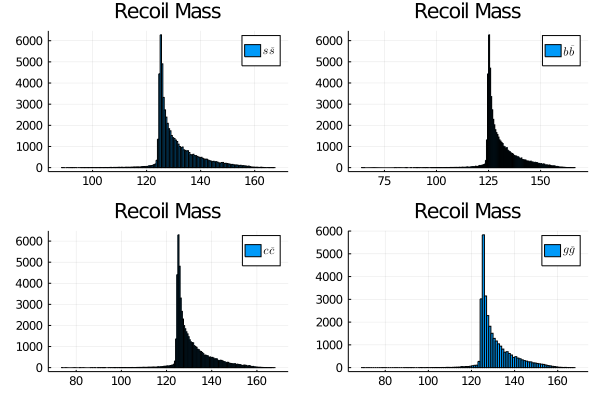

In [31]:
plot(
    histogram(recoilMass["ss"], label=L"s\bar{s}"),
    histogram(recoilMass["bb"], label=L"b\bar{b}"),
    histogram(recoilMass["cc"], label=L"c\bar{c}"),
    histogram(recoilMass["gg"], label=L"g\bar{g}"),
    layout=(2,2),
    title="Recoil Mass"
)

In [22]:
nEvent

Dict{Any,Any} with 4 entries:
  "ss" => 96500
  "bb" => 95500
  "gg" => 50000
  "cc" => 96500

In [23]:
perSampleFalsePosIndex #only have it for gg right now but the code for any sample is there

Dict{Any,Any} with 1 entry:
  "gg" => Any[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (…